In [49]:
import osmnx as ox, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [45]:
# boundary of Cape Town
ct = ox.gdf_from_place('City of Cape Town, South Africa')

In [46]:
# x and y bounds
west, south, east, north = ct.unary_union.buffer(0.1).bounds 

In [47]:
# geometry into polygon
geometry = ct['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])

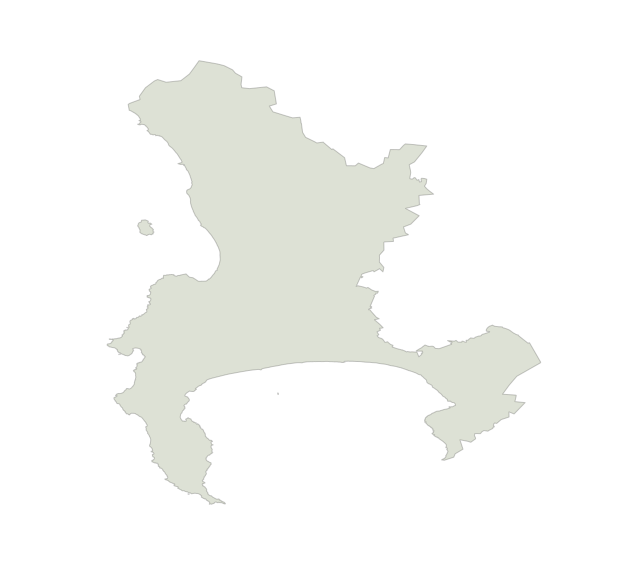

In [50]:
# plot the city

fig, ax = plt.subplots(figsize=(10,10))
    
for polygon in geometry: #plot shape of Cape Town
    patch = PolygonPatch(polygon, fc = "#556B2F", ec = 'k', alpha = 0.2, zorder = 2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [51]:
wc_schools = pd.read_excel("wc.xlsx") # western cape school database

In [52]:
y = wc_schools["GIS_Latitude"] # Latitude coordinate of school
x = wc_schools["GIS_Longitude"] #Longitude coordinate of school

In [53]:
learners = wc_schools["Learners_2016"] # amount of learners in school
educators = wc_schools["Educators_2016"] # amound of educators in school
lpe = [] # learners per educator
for i in range(len(learners)):
    lpe.append(learners[i]/educators[i])

In [54]:
gdf_nodes = gpd.GeoDataFrame(data={'x':x, 'y':y}) # network of schools coordinates
gdf_nodes.crs = ct.crs # system of starting coordinates (dict)
gdf_nodes.name = lpe # value is the ratio of learners per educator
gdf_nodes['geometry'] = gdf_nodes.apply(lambda row: Point((row['x'], row['y'])), axis=1) # 'geometry' col values

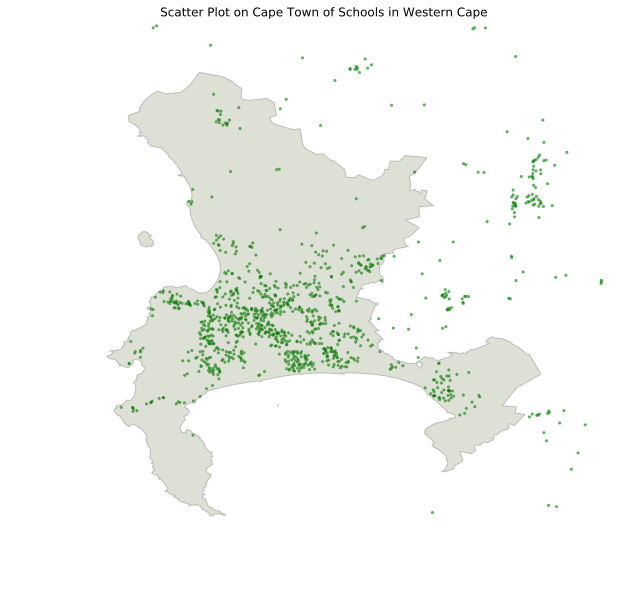

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)
    
plt.title("Scatter Plot on Cape Town of Schools in Western Cape")
ax.scatter(x=gdf_nodes['x'], y=gdf_nodes['y'], s=5, c='g', zorder=1, alpha = 0.5) # plotting schools
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.savefig("ct_1.png")
plt.show()

In [56]:
spatial_index = gdf_nodes.sindex # spatial index
# check which spatial indices intersect with our bounding box of the polygon (our city)
# possible, because there are no false negatives, but there can be false positives
# this happens when the bounding box in the R-Tree of the polygon has bounds greater than the polygon bounds
# in this case points outside the city but in this bounding box are false positives
possible_index = list(spatial_index.intersection(geometry.bounds)) 
possible_schools = gdf_nodes.iloc[possible_index] # fetch nodes of possible schools
# check if the possible schools intersect with our actual polygon
# this gives us the actual schools within
schools_ct = possible_schools[possible_schools.intersects(geometry)]

In [57]:
schools_not = gdf_nodes[~gdf_nodes.isin(schools_ct)] # schools outside Cape Town

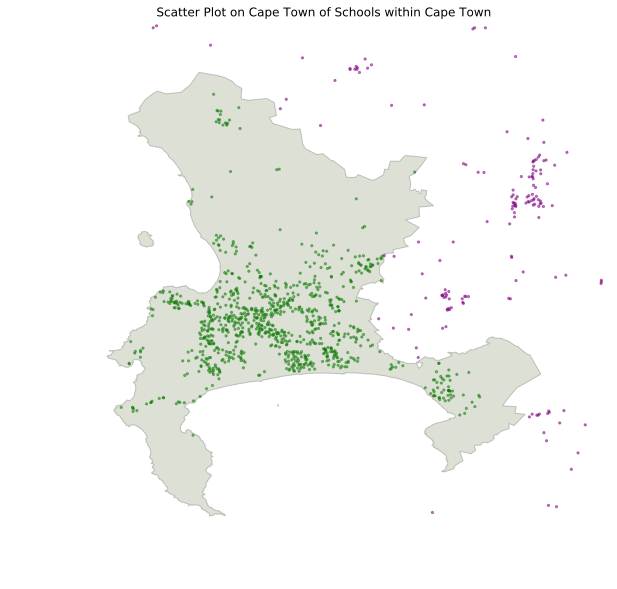

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)

plt.title("Scatter Plot on Cape Town of Schools within Cape Town")
ax.scatter(x=schools_not['x'], y=schools_not['y'], s=5, c='purple', zorder=1, alpha = 0.5)
ax.scatter(x=schools_ct['x'], y=schools_ct['y'], s=5, c='g', zorder=2, alpha = 0.5)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.savefig("ct_3.png")
plt.show()

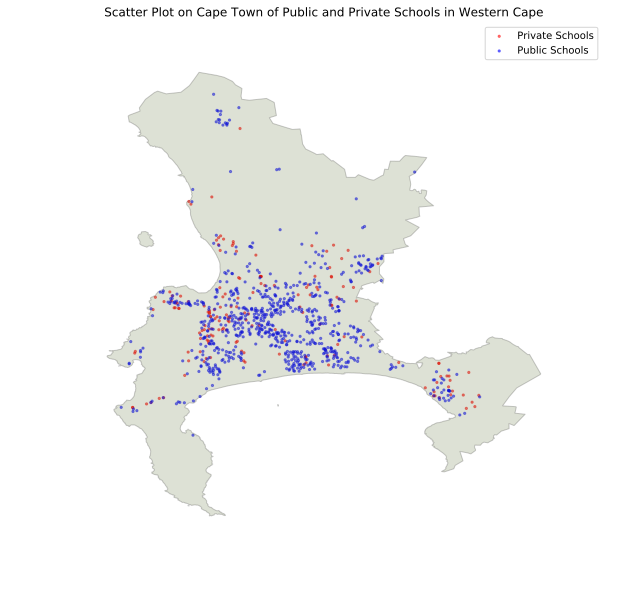

In [59]:
sector = wc_schools["Sector"] # public or independent school

private_lon = []
private_lat =[]
public_lon = []
public_lat = []

for i in schools_ct.index:
    if sector[i] == "INDEPENDENT": # private school coordinates
        private_lon.append(x[i])
        private_lat.append(y[i])
    else:
        public_lon.append(x[i])  # public school coordinates
        public_lat.append(y[i])
        

fig, ax = plt.subplots(figsize=(10,10))
for polygon in geometry:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)
    
plt.title("Scatter Plot on Cape Town of Public and Private Schools in Western Cape")
ax.scatter(private_lon, private_lat, s=5, c='r', zorder=1, alpha = 0.5, label = "Private Schools") 
ax.scatter(public_lon, public_lat, s=5, c='b', zorder=1, alpha = 0.5, label = "Public Schools") 
ax.legend()

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.savefig("ct_2.png")
plt.show()

In [60]:
schools_tsr = [] # empty list of teacher-student ratio for schools in Cape Town

for i in range(len(schools_ct)):
    index = schools_ct.index[i]
    schools_tsr.append(gdf_nodes.name[index])

In [61]:
import numpy as np

tsr = [x for x in schools_tsr if str(x) != 'nan'] # remove unknown values

print np.max(tsr)
print np.min(tsr)
print np.mean(tsr)

67.0
3.0
30.0552797797


In [62]:
# Compare to Ntabankulu in Eastern Cape
# repeat process
nt = ox.gdf_from_place('Alfred Nzo District Municipality, South Africa')

In [63]:
ec = pd.read_excel("ec.xlsx") # Eastern Cape schools database

In [64]:
y_ec = ec["GIS_Latitude"]
x_ec = ec["GIS_Longitude"]

In [65]:
learners_ec = ec["Learners_2016"]
educators_ec = ec["Educators_2016"]
lpe_ec = []
for i in range(len(learners_ec)):
    lpe_ec.append(learners_ec[i]/educators_ec[i])

In [66]:
geo_nt = nt['geometry'].iloc[0]
if isinstance(geo_nt, Polygon):
    geo_nt = MultiPolygon([geo_nt])

In [67]:
gdf_nodes_ec = gpd.GeoDataFrame(data={'x':x_ec, 'y':y_ec})
gdf_nodes_ec.crs = nt.crs
gdf_nodes_ec.name = lpe_ec # value is the ratio of learners per educator
gdf_nodes_ec['geometry'] = gdf_nodes_ec.apply(lambda row: Point((row['x'], row['y'])), axis=1)

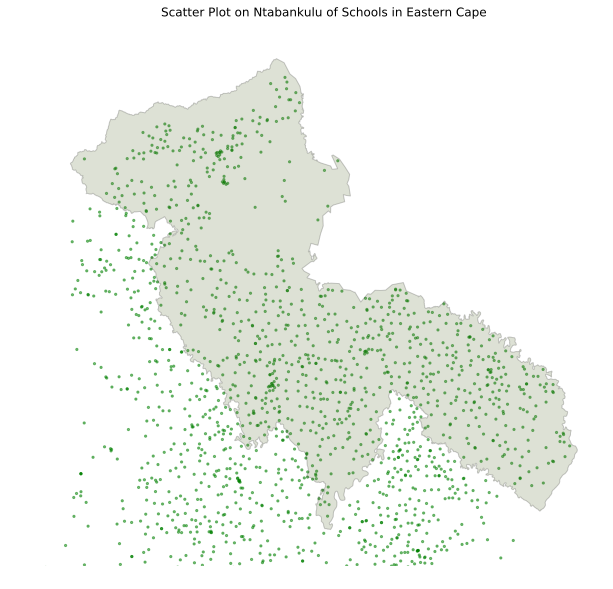

In [68]:
west_nt, south_nt, east_nt, north_nt = nt.unary_union.buffer(0.1).bounds

fig, ax = plt.subplots(figsize=(10,10))
for polygon in geo_nt:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)
    
    
plt.title("Scatter Plot on Ntabankulu of Schools in Eastern Cape")
ax.scatter(x=gdf_nodes_ec['x'], y=gdf_nodes_ec['y'], s=5, c='g', zorder=1, alpha = 0.5) 
ax.set_xlim(west_nt, east_nt)
ax.set_ylim(south_nt, north_nt)
ax.axis('off')
plt.savefig("nt_1.png")
plt.show()

In [69]:
spatial_index_ec = gdf_nodes_ec.sindex
possible_index_ec = list(spatial_index_ec.intersection(geo_nt.bounds))
possible_schools_ec = gdf_nodes_ec.iloc[possible_index_ec]
schools_nt = possible_schools_ec[possible_schools_ec.intersects(geo_nt)]

In [70]:
schools_not_nt = gdf_nodes_ec[~gdf_nodes_ec.isin(schools_nt)]

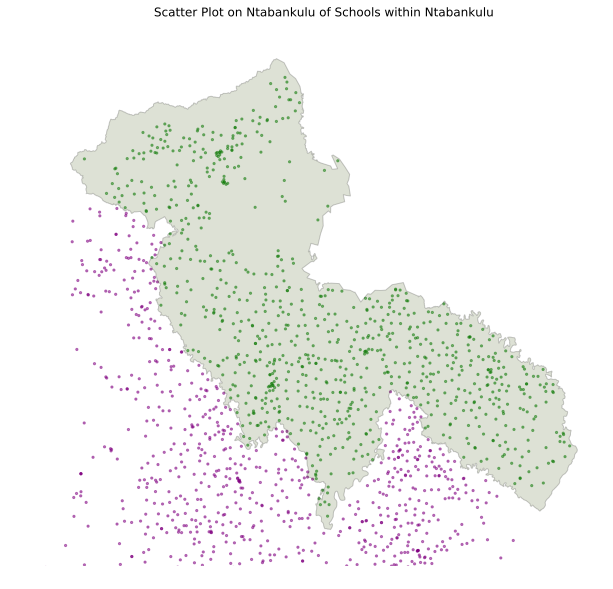

In [71]:
fig, ax = plt.subplots(figsize=(10,10))
for polygon in geo_nt:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=schools_not_nt['x'], y=schools_not_nt['y'], s=5, c='purple', zorder=1, alpha = 0.5)
ax.scatter(x=schools_nt['x'], y=schools_nt['y'], s=5, c='g', zorder=2, alpha = 0.5)

plt.title("Scatter Plot on Ntabankulu of Schools within Ntabankulu")
ax.set_xlim(west_nt, east_nt)
ax.set_ylim(south_nt, north_nt)
ax.axis('off')
plt.savefig("nt_3.png")
plt.show()

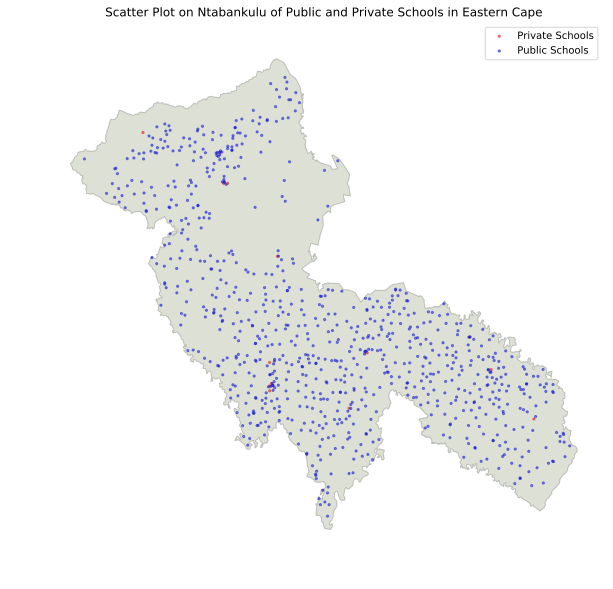

In [72]:
sector_ec = ec["Sector"] # public or independent school

private_lon_ec = []
private_lat_ec =[]
public_lon_ec = []
public_lat_ec = []

for i in schools_nt.index:
    if sector_ec[i] == "INDEPENDENT": # private school coordinates
        private_lon_ec.append(x_ec[i])
        private_lat_ec.append(y_ec[i])
    else:
        public_lon_ec.append(x_ec[i])  # public school coordinates
        public_lat_ec.append(y_ec[i])
        

fig, ax = plt.subplots(figsize=(10,10))
for polygon in geo_nt:
    patch = PolygonPatch(polygon, fc='#556B2F', ec='k', alpha=0.2, zorder=2)
    ax.add_patch(patch)
    
plt.title("Scatter Plot on Ntabankulu of Public and Private Schools in Eastern Cape")
ax.scatter(private_lon_ec, private_lat_ec, s=5, c='r', zorder=1, alpha = 0.5, label = "Private Schools")
ax.scatter(public_lon_ec, public_lat_ec, s=5, c='b', zorder=1, alpha = 0.5, label = "Public Schools") 
ax.legend()

ax.set_xlim(west_nt, east_nt)
ax.set_ylim(south_nt, north_nt)
ax.axis('off')
plt.savefig("nt_2.png")
plt.show()

In [73]:
schools_tsr_nt = []

for i in range(len(schools_nt)):
    index = schools_nt.index[i]
    schools_tsr_nt.append(gdf_nodes_ec.name[index])

In [74]:
tsr_nt = [x for x in schools_tsr_nt if str(x) != 'nan']

print np.max(tsr_nt)
print np.min(tsr_nt)
print np.mean(tsr_nt)

83.0
5.0
32.6217946461


In [75]:
from scipy.stats import ttest_ind
t, p = ttest_ind(tsr, tsr_nt)
print p

4.27283063584e-07
